## Importing Libraries

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download columbine/imdb-dataset-sentiment-analysis-in-csv-format

 66% 17.0M/25.7M [00:00<00:00, 63.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 72.9MB/s]


In [3]:
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tensorflow import keras

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 4)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Importing Dataset

In [4]:
zipname = '/content/imdb-dataset-sentiment-analysis-in-csv-format.zip'
with ZipFile(zipname,'r') as zip:
  zip.printdir()
zip.close()

File Name                                             Modified             Size
Test.csv                                       2019-11-28 15:44:12      6612442
Train.csv                                      2019-11-28 15:44:12     52724248
Valid.csv                                      2019-11-28 15:44:18      6525644


In [5]:
with ZipFile(zipname,'r') as zipf:
  zipf.extractall()
zipf.close()

In [6]:
data_train=pd.read_csv("/content/Train.csv")
data_valid=pd.read_csv("/content/Valid.csv")
data_test=pd.read_csv("/content/Test.csv")

## Exploratory Data Analysis

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [8]:
data_train.head()

,text,label
0,"I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played ""Thunderbirds"" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thu...",0
1,"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those...",0
2,"Why do people who do not know what a particular time in the past was like feel the need to try to define that time for others? Replace Woodstock with the Civil War and the Apollo moon-landing with the Titanic sinking and you've got as realistic a flick as this formulaic soap opera populated entirely by low-life trash. Is this what kids who were too young to be allowed to go to Woodstock and who failed grade school composition do? ""I'll show those old meanies, I'll put out my own movie and pr...",0
3,"Even though I have great interest in Biblical movies, I was bored to death every minute of the movie. Everything is bad. The movie is too long, the acting is most of the time a Joke and the script is horrible. I did not get the point in mixing the story about Abraham and Noah together. So if you value your time and sanity stay away from this horror.",0
4,"Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant move - especially when he wouldn't cash the cheque (something that is rarely done now).<br /><br />It f...",1


## Data Preprocessing

### Data Cleaning
* Lower Text
* Remove Punctuation Marks
* Remove Stopwords
* Remove URLs
* Remove text blobs
* Remove Multiple Spaces

In [9]:
def preprocess_data(data = None, stopwords = None, rm_stopwords = True):
    
    def lower_text(data = None):
        """
        Converts everyword to lower case
        Returns : Pandas DataFrame
        """
        data['text'] = data['text'].apply(lambda x : str(x).lower())
        return data
        
    def remove_punctuation(data = None):
        """
        Removes Punctuation Marks and br tags
        Returns : Pandas DataFrame
        """
        data['text'] = data['text'].apply(lambda x : re.sub(r'[^\w\s]+','',x))
        data['text'] = data['text'].apply(lambda x : re.sub(r'<br\s?/?>',' ',x))
        return data
    
    def remove_stopwords(data = None, stopwords = None):
        """
        Removes Stopwords
        Returns : Pandas DataFrame
        """
        data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))
        return data
    
    def remove_url(match_expr = r'([^\s]+www[^\s]+)|([^\s]+https?[^\s]+)', data = None):
        """
        Removes URL that contain http|https|www using Regular Expressions
        Returns : Pandas DataFrame
        """
        data['text'] = data['text'].apply(lambda x : re.sub(match_expr,' ',x))
        return data
    
    def remove_long_words(max_len = 30, data = None):
        """
        Removes blob of characters that are longer than 30 characters
        Returns : Pandas DataFrame
        """
        data['text'] = data['text'].apply(lambda x : re.sub(r'[^\s]{30,}',' ',x))
        return data

    def remove_multiple_spaces(data = None):
        """
        Removes continually occurin spaces.
        Returns : Pandas DataFrame
        """
        data['text'] = data['text'].apply(lambda x : re.sub(r'\s{2,}',' ',x))
        return data
        
    data = lower_text(data=data)
    data = remove_url(data=data)
    data = remove_long_words(data=data)
    if rm_stopwords:
        data = remove_stopwords(data=data,stopwords=stopwords)
    data = remove_punctuation(data)
    data = remove_multiple_spaces(data=data)
    
    return data

### Stopwords

In [10]:
stopword_list = stopwords.words('english')

In [11]:
X = preprocess_data(data_train,stopword_list)
X_valid = preprocess_data(data_valid,stopword_list)
X_test = preprocess_data(data_test,stopword_list)

### Tokenization

In [12]:
def get_tokens(data = None):
    train_tokens = data['text'].apply(lambda x : word_tokenize(x))
    return train_tokens

In [13]:
X = get_tokens(X)
X_valid = get_tokens(X_valid)
X_test = get_tokens(X_test)

### Lemmitization

In [14]:
def get_lemmatization(token_list = None):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    lemmatized_sent = []
    
    for tokens in token_list:
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
        lemmatized_sent.append(" ".join(lemmatized_tokens))
        
    return lemmatized_sent

In [15]:
X = get_lemmatization(X)
X_valid = get_lemmatization(X_valid)
X_test = get_lemmatization(X_test)

In [16]:
len(X)

40000

> What is the average number of words in each text?

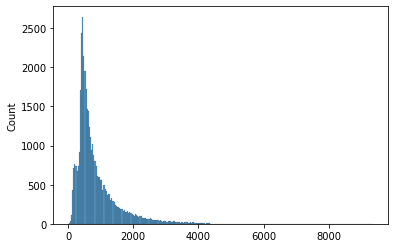

In [17]:
X_lengths = np.array([len(X[i]) for i in range(len(X))])
sns.histplot(X_lengths)

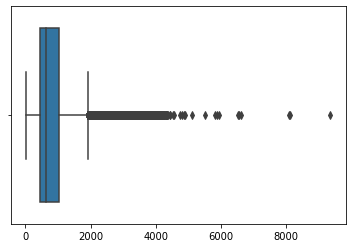

In [18]:
sns.boxplot(x=X_lengths)

### Visualizing Bigrams

In [48]:
from collections import Counter
def create_corpus(data=None):
    corpus=[]
    
    for sent in data[0].str.split():
        for word in sent:
            corpus.append(word)
    return corpus

#### Negative

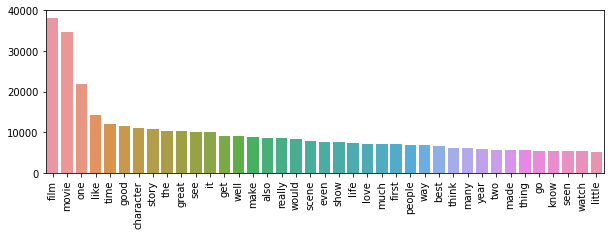

In [53]:
positive = pd.DataFrame(X)
positive = positive[data_train['label'] == 1]

counter_positive=Counter(create_corpus(positive))
most_positive=counter_positive.most_common()
plt_X=[]
plt_y=[]
for word,count in most_positive[1:40]:
    plt_X.append(word)
    plt_y.append(count)

fig, ax = plt.subplots(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x=plt_X,y=plt_y,ax=ax)

#### Positive

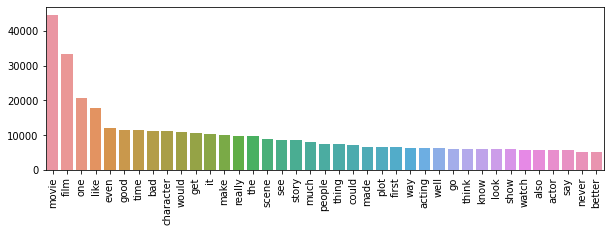

In [54]:
negative = pd.DataFrame(X)
negative = negative[data_train['label'] == 0]

counter_negative=Counter(create_corpus(negative))
most_negative=counter_negative.most_common()
plt_X=[]
plt_y=[]
for word,count in most_negative[1:40]:
    plt_X.append(word)
    plt_y.append(count)

fig, ax = plt.subplots(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x=plt_X,y=plt_y,ax=ax)

### Visualize Positive and Negative Words

#### Positive

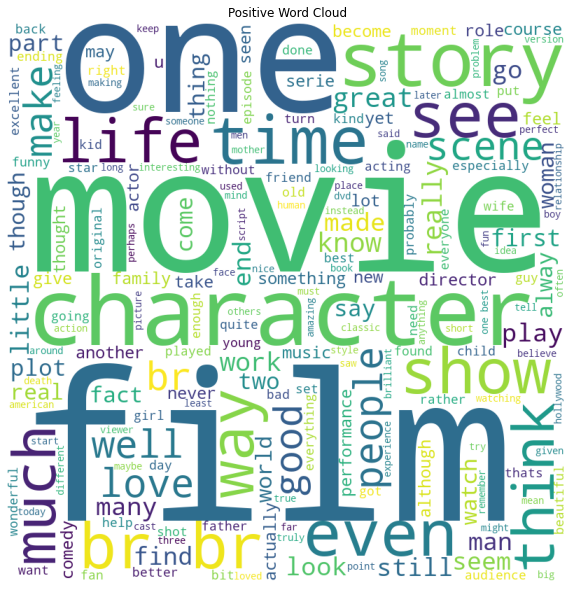

In [63]:
from wordcloud import WordCloud, STOPWORDS
positive.columns = ['text']
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(positive.text)+" ")
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Positive Word Cloud')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Negative

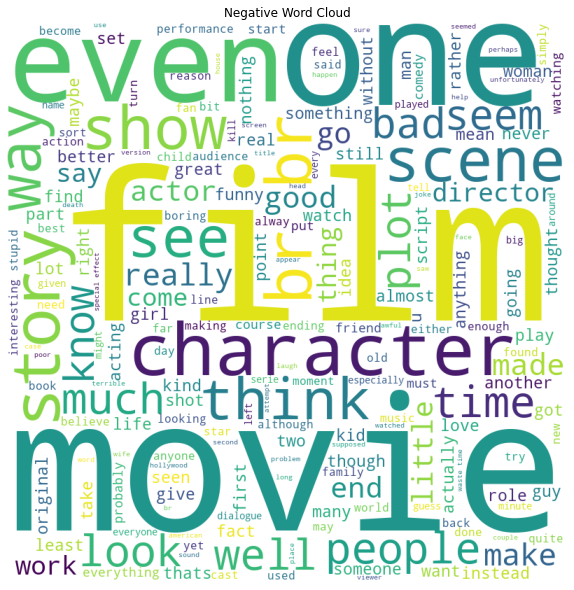

In [64]:
negative.columns = ['text']
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(negative.text)+" ")
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Negative Word Cloud')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Saving Data as Checkpoint

In [ ]:
Xd = X
X_validd = X_valid
X_testd = X_test

In [ ]:
X = Xd
X_valid = X_validd
X_test = X_testd

### Convert string to Input

In [ ]:
size_of_vocabulary = 100000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = size_of_vocabulary , split=' ')
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad Sequences to make them equal in dimensions

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(
    X,
    dtype='int',
    padding='post',
)
X_valid = tf.keras.preprocessing.sequence.pad_sequences(
    X_valid,
    maxlen=X.shape[1],
    dtype='int',
    padding='post',
)
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test,
    maxlen=X.shape[1],
    dtype='int',
    padding='post',
)

In [ ]:
X.shape

(40000, 1471)

In [ ]:
X_valid.shape

(5000, 886)

In [ ]:
y = np.array(data_train['label'],dtype='float64')
y_valid = np.array(data_valid['label'],dtype='float64')
y_test = np.array(data_test['label'],dtype='float64')

In [ ]:
X.shape

(40000, 1471)

### LSTM Model

In [ ]:
def get_lstm(input_dim = None,output_dim = None,input_shape = None):

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim,
      output_dim,
      input_length=input_shape[1])
  )

  model.add(tf.keras.layers.SpatialDropout1D(0.3))

  lstm_layers = 8
  for i in range(lstm_layers):
    model.add(tf.keras.layers.LSTM(16, activation='tanh', return_sequences=True,dropout=0.2))

  model.add(tf.keras.layers.GlobalMaxPooling1D())

  model.add(tf.keras.layers.Dense(units=64,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(units=32,activation='relu'))

  model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(clipvalue=0.0005),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=tf.keras.metrics.BinaryAccuracy(),
  )

  return model

In [ ]:
model_lstm = get_lstm(input_dim = size_of_vocabulary ,output_dim = 256,input_shape = X.shape)

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1471, 256)         25600000  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1471, 256)        0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 1471, 16)          17472     
                                                                 
 lstm_9 (LSTM)               (None, 1471, 16)          2112      
                                                                 
 lstm_10 (LSTM)              (None, 1471, 16)          2112      
                                                                 
 lstm_11 (LSTM)              (None, 1471, 16)          2112      
                                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.05,
    patience=3,
    mode="min",
)

history_lstm = model_lstm.fit(
    x = X,
    y = y,
    validation_split = 0.25,
    epochs = 10,
    batch_size = 64,
    callbacks = [early_stopping]
)

Epoch 1/20
469/469 [==============================] - 212s 424ms/step - loss: 0.5127 - binary_accuracy: 0.7332 - val_loss: 0.3514 - val_binary_accuracy: 0.8464
Epoch 2/20
469/469 [==============================] - 188s 401ms/step - loss: 0.2747 - binary_accuracy: 0.8983 - val_loss: 0.3053 - val_binary_accuracy: 0.8836
Epoch 3/20
469/469 [==============================] - 197s 420ms/step - loss: 0.1741 - binary_accuracy: 0.9403 - val_loss: 0.4116 - val_binary_accuracy: 0.8592
Epoch 4/20
469/469 [==============================] - 189s 404ms/step - loss: 0.1100 - binary_accuracy: 0.9675 - val_loss: 0.4031 - val_binary_accuracy: 0.8661
Epoch 5/20
469/469 [==============================] - 190s 405ms/step - loss: 0.0803 - binary_accuracy: 0.9785 - val_loss: 0.5750 - val_binary_accuracy: 0.8563
Epoch 6/20
469/469 [==============================] - 169s 361ms/step - loss: 0.0666 - binary_accuracy: 0.9833 - val_loss: 0.5339 - val_binary_accuracy: 0.8635


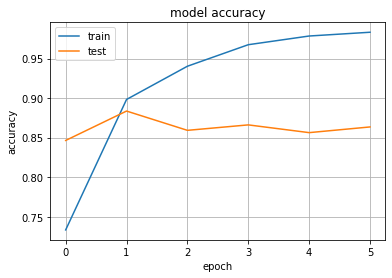

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_lstm.history['binary_accuracy'])
plt.plot(history_lstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
model_lstm.evaluate(X_valid,y_valid)

157/157 [==============================] - 22s 140ms/step - loss: 0.4995 - binary_accuracy: 0.8700


[0.49949443340301514, 0.8700000047683716]

## Testing on Custom Dataset

In [ ]:
model_lstm.save('lstm_model')

In [ ]:
test_list = []
test_list.append("This was a great movie, it shows the complexity of human nature and how sad incidents can lead to good times.")
test_list.append("Good movie but the hero was a little too dull however this does not stop it from being a good movie")
test_list.append("really great show, the actors were so great throughout the movie. They deserve to win all the awards")
test_list.append("the writing and direction of the movie was pathetic and the roles did not fit the actors")
test_list.append("thoroughly analysing the movie, we find that the lead role was suffering through several problems in his lifetime which he was not able to sort however these problems create a really well written character arc and an amazing story for viewers")
test_list.append("absolutely terrible, did not enjoy a second of the movie")
test_list.append("absolutely terrible, did not enjoy a second of the movie although the start was good, the end was horrible")
test_list.append("a must watch series for anyone who loves Harry Potter")
test_list.append("do not watch this series if you love Harry Potter")
test_list.append("if you love harry potter, you will not like this")

test_list_label = [
    1,1,1,0,1,0,0,1,0,0
]


In [ ]:
test_list = pd.DataFrame(test_list)
test_list.columns = ['text']
test_list = preprocess_data(test_list,stopword_list)
test_list = get_tokens(test_list)
test_list = get_lemmatization(test_list)
test_list = tokenizer.texts_to_sequences(test_list)
test_list = tf.keras.preprocessing.sequence.pad_sequences(
    test_list,
    maxlen=1471,
    dtype='int',
    padding='post',
)

In [ ]:
test_list

array([[  23,    2,   26, ...,    0,    0,    0],
       [   7,    2,  401, ...,    0,    0,    0],
       [  17,   23,   26, ...,    0,    0,    0],
       ...,
       [ 129,   35,  127, ...,    0,    0,    0],
       [  35,  127,   36, ...,    0,    0,    0],
       [  36, 1298, 6108, ...,    0,    0,    0]])

In [ ]:
test_list_label = np.array(test_list_label)
model_lstm.evaluate(test_list,test_list_label)

1/1 [==============================] - 3s 3s/step - loss: 0.7853 - binary_accuracy: 0.6000


[0.7852923274040222, 0.6000000238418579]

## Observations
1. Model Architecture  
  * Using more than 8 LSTM layers almost always leads to a stagnant loss that causes accuracy to be not more than 50%.
  * No amount of gradient clipping was able to fix this.
  * Another possible solution is to use less units in LSTM layer but the model does not learn many features on a large vocabulary size

2. Overfit
  * Model Overfits the training dataset.
  * Even after use of dropouts, the model is unable to learn all the features of the dataset.
  * A small amount of error can be attributed to the ambiguity of some comments, where it is difficult to assess the sentiment of the text, even by humans.
  * Future scope may use experimenting with larger architecture with use of recurrent dropouts.
3. Gradient Clipping
* Gradient Clipping is important while dealing with LSTMs.
* Using an Optimizer, clip gradients that are too big to avoid exploding and vanishing gradients

# Note: Due to GPU Constraints, Kindly refer to second notebook for rest of assignment